**Загрузка необходимых библиотек**



In [1]:
!pip install visualkeras

import visualkeras
import zipfile
import os

import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
import glob
import matplotlib.image as mpimg

import time
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, \
Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
# from keras_vggface.vggface import VGGFace


import pandas as pd
import numpy as np

# подключение гугл диска
from google.colab import drive
drive.mount('/content/drive')

# скрытие предупреждений
import warnings
warnings.filterwarnings("ignore")

# тут загрузим библиотеки для распознавания лиц

!pip install face_recognition
import face_recognition
import cv2

from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random


from google.colab.patches import cv2_imshow
from PIL import Image, ImageDraw

!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

print('tensorflow -',tf.__version__)
print('cv2 -',cv2.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 14.6 MB/s eta 0:00:00
Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=43936220cb50f0cca5aa97c850397b014ed30dd94c026c08a64c481c1cb15d85
  Stored in directory: /root/.cache/pip/wheels/b4/4b/8f/751e99d45f089bdf366a7d3e5066db3c2b84a62e4377f534d7
Successfully built face-recognition-models
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
tensorflow - 2.11.0
cv2 - 4.6.0


**Загрузка изначального датасета**

In [ ]:
# путь к тренировочному файлу
train_zip_file = '/content/drive/MyDrive/diplom/train.zip'
# распаковать файлы
train_files = zipfile.ZipFile(train_zip_file, 'r')
train_files.extractall()


**Тут объявим переменные, которые понадобятся в дальнейшем исследовании**


In [3]:
data_dir = '/content/train'
NUM_CLASSES = 9

**Функции для визуализации, обработки и др. вещей**


In [4]:
# для визуализации по пути к папке с файлами изображений
def show_image(data):
    """
    Отображает изображения 
    Принимает на вход путь к папке с файлами
    """
    idx_list = random.sample(range(0, len(glob.glob(data+'/*/*.*'))), 9)
    plt.figure(figsize=(10, 10))
    for i in range(9):
      idx = idx_list[i]
      plt.subplot(3,3, i+1)
      plt.xticks([])
      plt.yticks([])
      # эта строка для выделения названия эмоции из пути
      plt.title(glob.glob(data+'/*/*.*')[idx][len(data)+1:len(data_dir)+1+glob.glob(data+'/*/*.*')[idx][len(data_dir)+1:].find('/')])
      plt.grid(False)
      image_path = glob.glob(data+'/*/*.*')[idx]
      img = mpimg.imread(image_path)
      plt.imshow(img)

# для теста времени инференса моделей
def test_time_model(model, iter=300):
    
    image = face_recognition.load_image_file('/content/train_filter_fr3/contempt/0_10.jpg')
    input_arr = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE), interpolation=cv2.INTER_AREA)
    input_arr = preprocess_input(input_arr)
    input_arr = np.array([input_arr])  # Convert single image to a batch.

    _times = []
    for i in range(iter):
        start = time.time()
        model.predict(input_arr)
        _times.append(time.time() - start)
    mean_time = np.mean(_times)
    median_time = np.median(_times)
    plt.plot(_times)
    plt.title(f'Время работы модели после {iter} итераций на одном фото\n'
              f'среднее время = {mean_time:.3f}сек, медианное время = {median_time:.3f}сек')
    plt.xlabel('Количество итераций')
    plt.ylabel('Время инференса, сек')
    plt.show()
    return mean_time, median_time

# для изображения фото по путям в датасете
def show_image_from_dfpath(data):
    """
    Отображает изображения 
    data['emotion'] - названия эмоций
    data['path'] - пути к файлам
    """
    plt.figure(figsize=(15, 10))
    for i in range(6):
      idx = random.randint(0, len(data))
      plt.subplot(2,3, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.title(data['emotion'][idx])
      plt.grid(False)
      image_path = data['path'][idx]
      img = mpimg.imread(image_path)
      plt.imshow(img)



**Посмотрим на датасет**

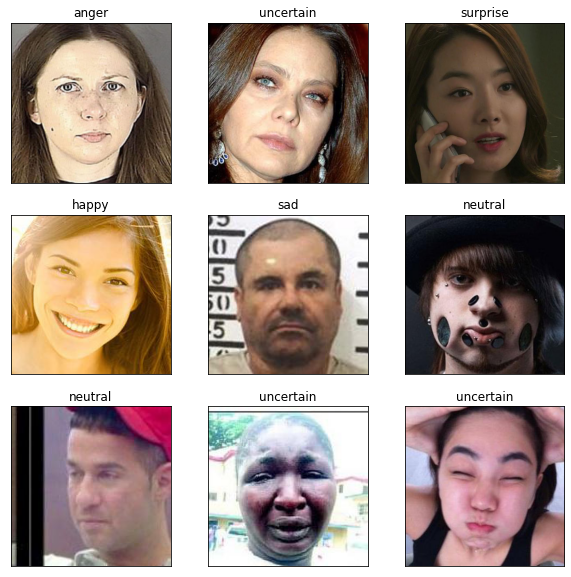

In [ ]:
show_image(data_dir)

Всего файлов:  50047


<BarContainer object of 9 artists>

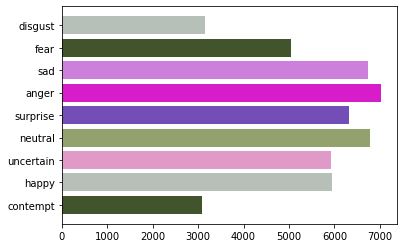

In [ ]:
# проведем разведочный анализ (для презентации)
# количество файлов по папкам

class_names = ['contempt',
 'happy',
 'uncertain',
 'neutral',
 'surprise',
 'anger',
 'sad',
 'fear',
 'disgust']

print('Всего файлов: ', len(glob.glob(data_dir+'/*/*.*')))

count_img = []
for i in class_names:
  count_img.append(len(glob.glob(data_dir+'/'+i+'/*.*')))

plt.barh(class_names, count_img, color = np.random.rand(7, 3))

**Для фильтрации файлов использовал facerecognition. Этот детектор хоть и более медленный, чем cv2, но более качественно определяет лица. Файлы с лицами, вырезанными по boundigbox, сохраняем в отдельный датасет**

In [ ]:



targ_folder = '/content/drive/MyDrive/train_filter_fr'


df_corrupt = dict()

rootDir = '/content/train'


idx = 0
for lists in os.listdir(rootDir): # перебирает папки с эмоциями

    path = os.path.join(rootDir, lists)
    target_path = os.path.join(targ_folder, lists)
    if not os.path.exists(target_path):
      # Каталог не существует, создайте операцию
      os.makedirs(target_path)  
    for img_name in tqdm(os.listdir(path)): # перебирает имена файлов
        img_path = os.path.join(path, img_name) # объединяет имена файлов с путями
        img_path_target = os.path.join(target_path, img_name)


        image_fr = face_recognition.load_image_file(img_path)
        face_locations = face_recognition.face_locations(image_fr)

        # если faces = 1 все ок - сохраняем
        
        if len(face_locations) >=1: # первая проверка fr
          count = 0
          
          for face_location in face_locations:
            top, right, bottom, left = face_location
            face_image_local = image_fr[top:bottom, left:right]
            face_locations_local = face_recognition.face_locations(face_image_local)
            # если лицо определено сохраняем фрагмент
            if len(face_locations_local) >=1: # вторая проверка fr
              
              img_name_local = str('{}_{}'.format(count, img_name))

              img_path_target=os.path.join(target_path, img_name_local)
              pil_image = Image.fromarray(face_image_local)
              
              pil_image.save(img_path_target)

              count += 1
          if count == 0:
            df_corrupt[idx] = {'path': img_path}
            idx += 1                  
        



            

100%|██████████| 5955/5955 [56:35<00:00,  1.75it/s]


In [ ]:
train_df = pd.DataFrame(df_corrupt).T

**Сохраним датасет с нераспознанными фото**

In [ ]:
filehandler = open("/content/drive/MyDrive/diplom/train_df.obj","wb")
pickle.dump(train_df,filehandler)
filehandler.close() 

**Загрузка датасета**

In [ ]:
file = open("/content/drive/MyDrive/diplom/train_df.obj",'rb')
train_df = pickle.load(file)
file.close()

**Добавим в датасет столбец с эмоциями**

In [ ]:
train_df['emotion']=0
for i in train_df['path'].index:
  train_df['emotion'][i] = train_df['path'][i][15:train_df['path'][i][15:].find('/')+15]

In [ ]:
train_df.head()

,path,emotion
0,/content/train/fear/2536.jpg,fear
1,/content/train/fear/3625.jpg,fear
2,/content/train/fear/3158.jpg,fear
3,/content/train/fear/1856.jpg,fear
4,/content/train/fear/912.jpg,fear


**Посмотрим на "бракованные" фото**

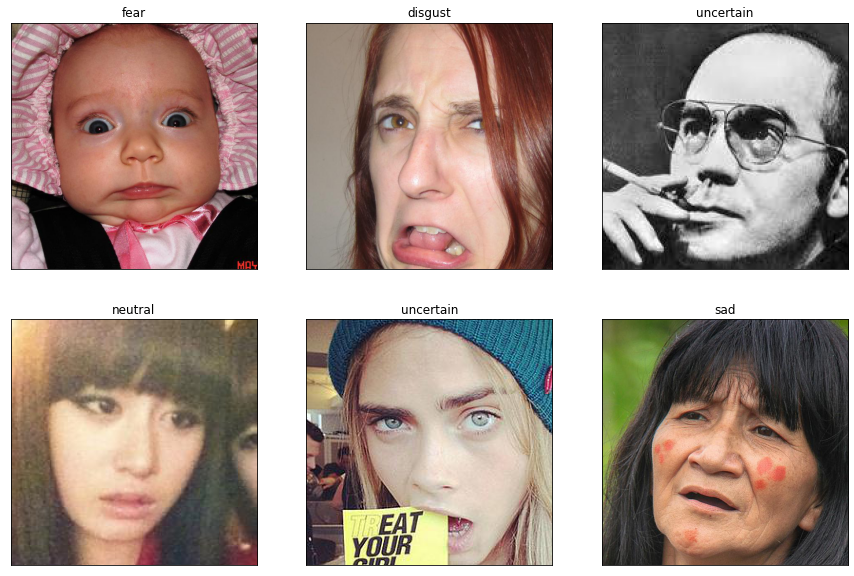

In [ ]:
show_image_from_dfpath(data=train_df)

Всего файлов:  43913


<BarContainer object of 9 artists>

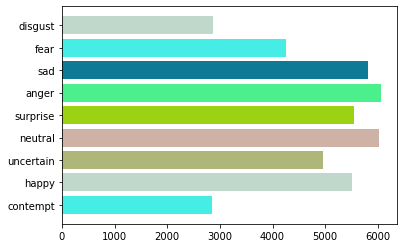

In [ ]:
# проведем разведочный анализ обработанного датасета (для презентации)
# количество файлов по папкам

targ_folder = '/content/drive/MyDrive/train_filter_fr'
print('Всего файлов: ', len(glob.glob(targ_folder+'/*/*.*')))

count_img = []
for i in class_names:
  count_img.append(len(glob.glob(targ_folder+'/'+i+'/*.*')))
  # print(len(glob.glob(data_dir+'/'+i+'/*.*'))
plt.barh(class_names, count_img, color = np.random.rand(7, 3))

Как видим, датасет сократился на примерно 6к фото. Отбракованные фото или размыты, с очками, руками, другими помехами. Потери приемлемы, думаю на качество обучения не повлияют.

**Для ускорения работы новый датасет заархивируем**

In [ ]:
directory = pathlib.Path('/content/drive/MyDrive/train_filter_fr')

with zipfile.ZipFile('/content/drive/MyDrive/train_filter_fr3.zip', mode="w") as archive:
  for file_path in tqdm(directory.rglob("*")):
    archive.write(file_path, arcname=file_path.relative_to(directory))


43922it [16:42, 43.79it/s] 


**Распакуем обработанный архив в рабочую директорию**

In [ ]:
# путь к тренировочному файлу

train_zip_file = '/content/drive/MyDrive/train_filter_fr3.zip'

# распаковать файлы
train_files = zipfile.ZipFile(train_zip_file, 'r')
train_files.extractall(path='/content/train_filter_fr3')
# print(os.listdir('.train'))

**Посмотрим на фото**

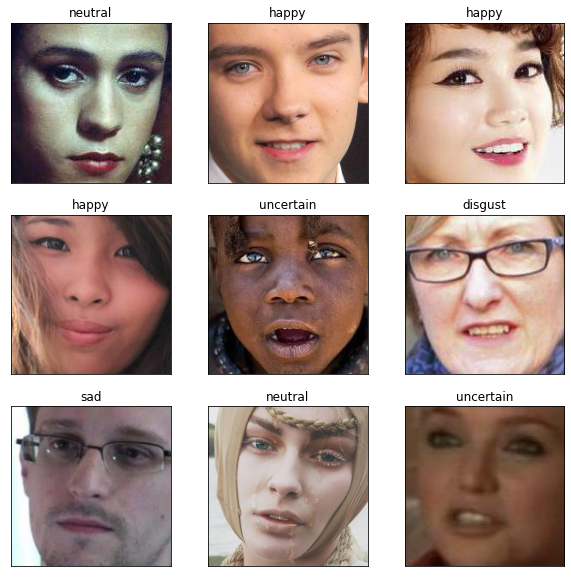

In [ ]:
data_dir = '/content/train_filter_fr3'
show_image(data_dir)

**Приступим к обучению моделей**

объявим переменные

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = 128
# data_dir = '/content/train_filter_fr3'

**Параметры аугментации и подготовку данных сведем в функцию, в которой зашиты два датасета - обработанный и оригинальный**

In [ ]:
def loading_dataset(version_ds, bath_size, image_size):
  if version_ds == 1:
    '''
    version_ds == 1 - обработанный FR датасет
    '''
    data_dir = '/content/train_filter_fr3'
    image_gen = ImageDataGenerator(preprocessing_function=preprocess_input, # препроцессинг
                               validation_split=0.2, # размер валидационной выборки, так как всё берётся из одной папки
                               rotation_range=5,  # максимальный угол поворота
                               width_shift_range=0.1, # смещение максимум на 10% ширины по горизонтали
                               height_shift_range=0.1, # смещение максимум на 10% высоты по вертикали
                               zoom_range=0.1, # картинка будет увеличена или уменьшена не более чем на 10%
                               brightness_range=(0.4, 1.0), # сдвиг яркости
                               channel_shift_range=80.0, # случайный сдвиг каналов
                               shear_range = 0.1, # Интенсивность сдвига (угол сдвига против часовой стрелки в градусах)
                               horizontal_flip=True, # случайное отражение по горизонтали
                               fill_mode="nearest") # чем заполнять пробелы

    train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE, # размер батча  
                                                  directory=data_dir, # директория для доступа к изображениям
                                                  shuffle=True, # перемешивать ли данные 
                                                  target_size=(IMAGE_SIZE,IMAGE_SIZE), # размер изображения
                                                  class_mode="categorical", # тип классового распределения
                                                  subset = "training") # указываем, что данная выборка тренировочная 

    val_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                                directory=data_dir,
                                                shuffle=False,
                                                target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                class_mode='categorical',
                                                subset = "validation") # указываем, что данная выборка валидационная 
  elif version_ds == 2:
    '''
    version_ds == 2 - первоначальный датасет без обработки
    '''
    data_dir = '/content/train'
    image_gen = ImageDataGenerator(preprocessing_function=preprocess_input, # препроцессинг
                               validation_split=0.2, # размер валидационной выборки, так как всё берётся из одной папки
                               rotation_range=5,  # максимальный угол поворота
                               width_shift_range=0.1, # смещение максимум на 10% ширины по горизонтали
                               height_shift_range=0.1, # смещение максимум на 10% высоты по вертикали
                               zoom_range=0.1, # картинка будет увеличена или уменьшена не более чем на 10%
                               brightness_range=(0.4, 1.0), # сдвиг яркости
                               channel_shift_range=80.0, # случайный сдвиг каналов
                               shear_range = 0.1, # Интенсивность сдвига (угол сдвига против часовой стрелки в градусах)
                               horizontal_flip=True, # случайное отражение по горизонтали
                               fill_mode="nearest") # чем заполнять пробелы

    train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE, # размер батча  
                                                  directory=data_dir, # директория для доступа к изображениям
                                                  shuffle=True, # перемешивать ли данные 
                                                  target_size=(IMAGE_SIZE,IMAGE_SIZE), # размер изображения
                                                  class_mode="categorical", # тип классового распределения
                                                  subset = "training") # указываем, что данная выборка тренировочная 

    val_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                                directory=data_dir,
                                                shuffle=False,
                                                target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                class_mode='categorical',
                                                subset = "validation") # указываем, что данная выборка валидационная 


  labels_dict = {v: k for k,v in train_data_gen.class_indices.items()}
  return train_data_gen, val_data_gen, labels_dict


**Проверим первую модель VGG19 на этих наборах**




In [ ]:
NUM_CLASSES = 9
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

In [ ]:
train_data_gen, val_data_gen, labels_dict = loading_dataset(version_ds = 1, bath_size = BATCH_SIZE, image_size = IMAGE_SIZE)

Found 35133 images belonging to 9 classes.
Found 8780 images belonging to 9 classes.


In [ ]:

path = Path("/content/drive/My Drive/diplom/model_save_ocv/checkpoint_best128_original_19-02.h5")
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet') 
base_model.trainable = True

80134624/80134624 [==============================] - 5s 0us/step


**Перед обучением посмотрим структуру модели (для презентации)**

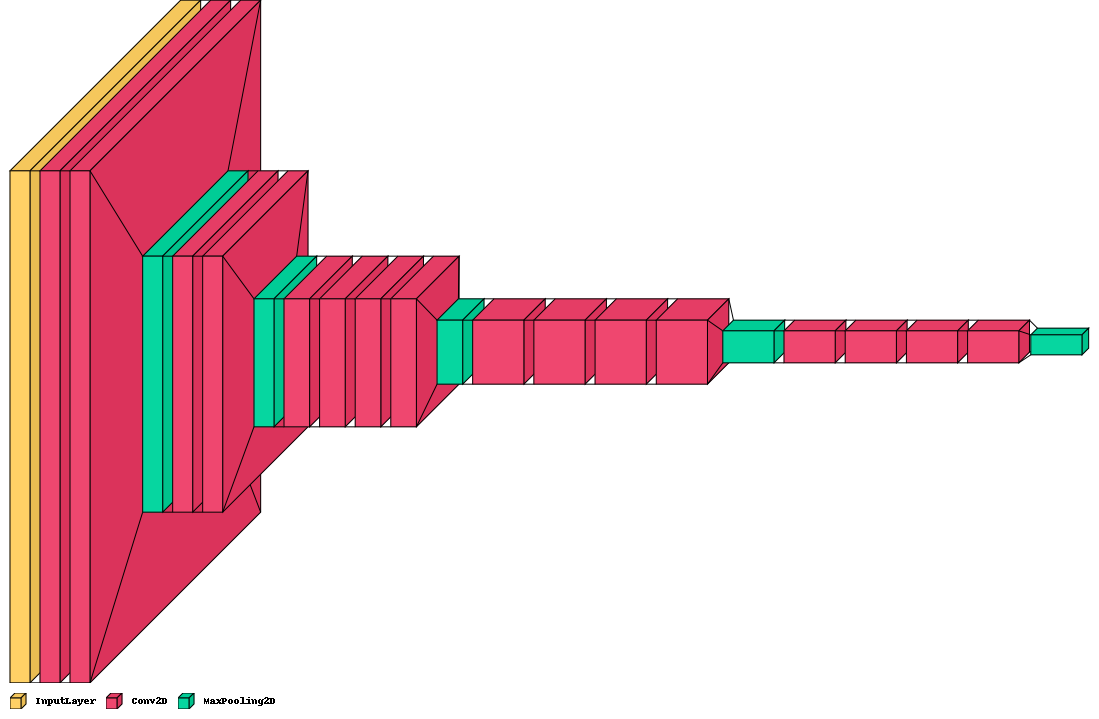

In [ ]:
visualkeras.layered_view(base_model, legend = True)

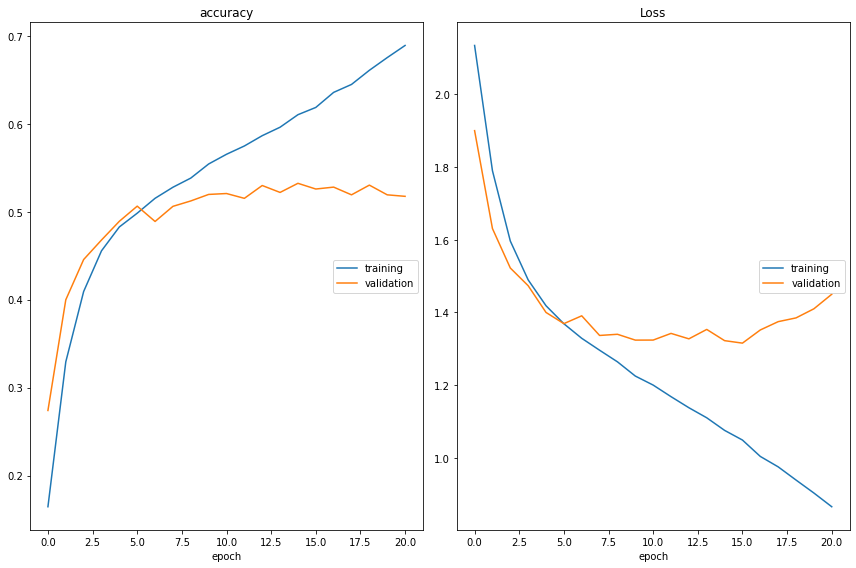

accuracy
	training         	 (min:    0.165, max:    0.689, cur:    0.689)
	validation       	 (min:    0.274, max:    0.532, cur:    0.518)
Loss
	training         	 (min:    0.865, max:    2.135, cur:    0.865)
	validation       	 (min:    1.316, max:    1.900, cur:    1.450)

Epoch 21: val_accuracy did not improve from 0.53235
549/549 [==============================] - 464s 845ms/step - loss: 0.8653 - accuracy: 0.6891 - val_loss: 1.4500 - val_accuracy: 0.5175
Epoch 22/30
 41/549 [=>............................] - ETA: 5:53 - loss: 0.7976 - accuracy: 0.7130

Process Keras_worker_ForkPoolWorker-71:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.8/dist-packages/keras/utils/data_utils.py", line 600, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)
  File "/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(
  File "/usr/local/lib/python3.8/dist-packages/keras/utils/image_utils.py", line 479, in load_img
    img = img.resize(width_height_tup

In [ ]:
model = tf.keras.Sequential([base_model,
                            tf.keras.layers.GlobalAveragePooling2D(),
                            tf.keras.layers.Dense(1024, activation="relu"),
                            tf.keras.layers.Dropout(0.3),
                            tf.keras.layers.Dense(NUM_CLASSES)])

"""

"""

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

EPOCHS = 30
history = model.fit_generator(train_data_gen,
                              epochs=EPOCHS,
                              validation_data=val_data_gen,
                              use_multiprocessing = True,
                              callbacks=[PlotLossesCallback(), checkpoint])

**Проверим быстродействие модели на одном фото**

In [ ]:
# загрузка модели
path = Path("/content/drive/My Drive/diplom/model_save_ocv/checkpoint_best128_original_19-02.h5")
model = tf.keras.models.load_model(path)


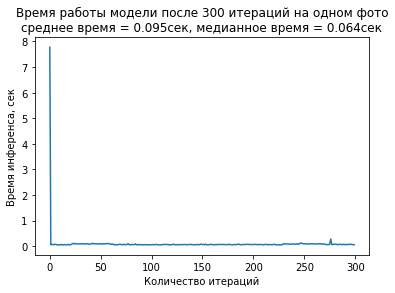

(0.09477392435073853, 0.06417238712310791)

In [ ]:
%%capture --no-display
test_time_model(model = model)

Время работы - около 7 сотых секунды на итерацию

**Распакуем тестовый датасет для проверки качества модели**

In [ ]:
# путь к тестовому файлу

test_zip_file = '/content/drive/MyDrive/diplom/test_kaggle.zip'

# распаковать файлы
test_files = zipfile.ZipFile(test_zip_file, 'r')
test_files.extractall()


In [ ]:

# функция для формирования датасета в целях проверки качества модели на kaggle
def TraverFolders(rootDir, model, img_size):
  '''
  rootDir - путь к тестовому датасету, по умолчанию /content/test_kaggle
  сохраняет датафрейм в predict_df_sort
  '''
  # count = 0
  img_dict = dict()
  idx = 0
  class_names = {0: 'anger',
                  1: 'contempt',
                  2: 'disgust',
                  3: 'fear',
                  4: 'happy',
                  5: 'neutral',
                  6: 'sad',
                  7: 'surprise',
                  8: 'uncertain'}
  for lists in tqdm(os.listdir(rootDir)):
      
      
      
      
      path = os.path.join(rootDir, lists)
      image = tf.keras.utils.load_img(path, target_size = (img_size, img_size))
      input_arr = tf.keras.utils.img_to_array(image)

      input_arr = preprocess_input(input_arr)
      input_arr = np.array([input_arr])  # Convert single image to a batch.
      
      predictions = model.predict(input_arr)

      emotion = class_names[np.argmax(predictions)]

      file_name = path[21:]
      file_numer = int(file_name[:-4])
      img_dict[idx] = {'path': path, 'image_path': file_name, 'emotion': emotion, 'fn': file_numer}
      idx+=1

      # count +=1
      # if count >= 10:
      #   break

  predict_df = pd.DataFrame(img_dict).T
  predict_df_sort = predict_df.sort_values(by='fn', ignore_index=True)
  # predict_df.set_index('fn')
  # predict_df_sort = predict_df.sort_index()
  predict_df_sort = predict_df_sort[['image_path', 'emotion']]
  return predict_df_sort

In [ ]:
%%capture --no-display
output_predict = TraverFolders(rootDir='/content/test_kaggle', model = model, img_size = IMAGE_SIZE)
output_predict.to_csv('/content/drive/MyDrive/diplom/predict_df.csv', index=False) 
output_predict.head()

,image_path,emotion
0,0.jpg,sad
1,1.jpg,neutral
2,2.jpg,uncertain
3,3.jpg,uncertain
4,4.jpg,anger


**Результаты на kaggle**

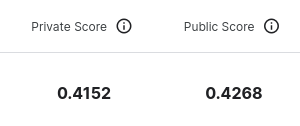

**Проверим ту же модель на оригинальном датасете (без обработки)**

In [ ]:
NUM_CLASSES = 9
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

In [ ]:
train_data_gen, val_data_gen, labels_dict = loading_dataset(version_ds = 2, bath_size = BATCH_SIZE, image_size = IMAGE_SIZE)

Found 40040 images belonging to 9 classes.
Found 10007 images belonging to 9 classes.


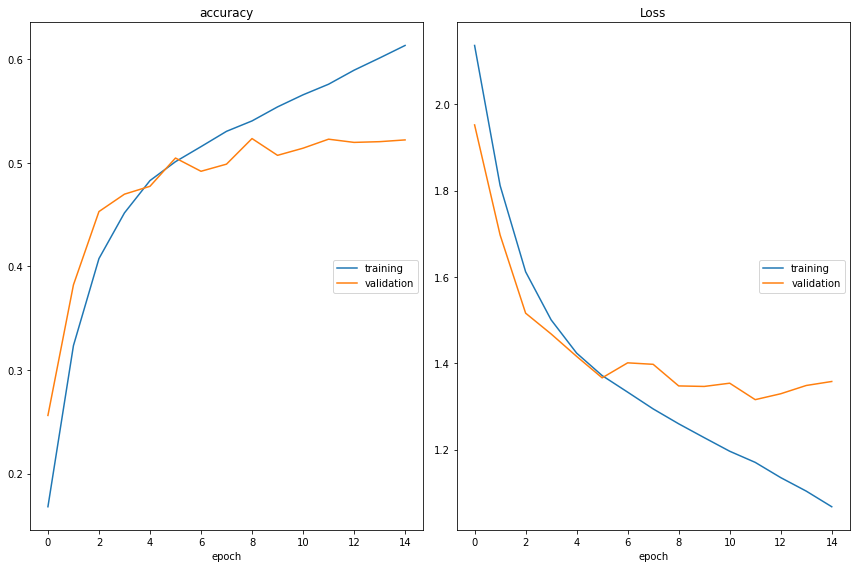

accuracy
	training         	 (min:    0.168, max:    0.613, cur:    0.613)
	validation       	 (min:    0.256, max:    0.523, cur:    0.522)
Loss
	training         	 (min:    1.068, max:    2.136, cur:    1.068)
	validation       	 (min:    1.316, max:    1.952, cur:    1.358)

Epoch 15: val_accuracy did not improve from 0.52343
626/626 [==============================] - 800s 1s/step - loss: 1.0676 - accuracy: 0.6133 - val_loss: 1.3578 - val_accuracy: 0.5221
Epoch 16/30
 13/626 [..............................] - ETA: 10:18 - loss: 1.0150 - accuracy: 0.6382

Process Keras_worker_ForkPoolWorker-54:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.8/dist-packages/keras/utils/data_utils.py", line 600, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)
  File "/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py", line 384, in _get_batches_of_transformed_samples
    x = self.image_data_generator.apply_transform(x, params)
  File "/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py", line 2011, in apply_transfor

KeyboardInterrupt: ignored

In [ ]:

path = Path("/content/drive/My Drive/diplom/model_save_ocv/checkpoint_best128_original_21-02.h5")
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet') 
base_model.trainable = True



model = tf.keras.Sequential([base_model,
                            tf.keras.layers.GlobalAveragePooling2D(),
                            tf.keras.layers.Dense(1024, activation="relu"),
                            tf.keras.layers.Dropout(0.3),
                            tf.keras.layers.Dense(NUM_CLASSES)])

"""

"""

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

EPOCHS = 30
history = model.fit_generator(train_data_gen,
                              epochs=EPOCHS,
                              validation_data=val_data_gen,
                              use_multiprocessing = True,
                              callbacks=[PlotLossesCallback(), checkpoint])

**Проверим быстродействие модели**

In [ ]:
# загрузка модели
path = Path("/content/drive/My Drive/diplom/model_save_ocv/checkpoint_best128_original_21-02.h5")
model = tf.keras.models.load_model(path)


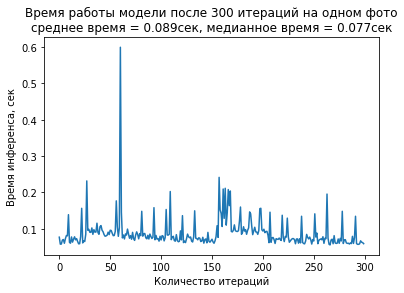

(0.08857648452123006, 0.0773932933807373)

In [ ]:
%%capture --no-display
test_time_model(model = model)

Время работы модели около 80 милисекунд на итерацию

**Загрузим на kaggle**

In [ ]:
%%capture --no-display
output_predict = TraverFolders(rootDir='/content/test_kaggle', model = model, img_size = IMAGE_SIZE)
output_predict.to_csv('/content/drive/MyDrive/diplom/predict_df_21.02.csv', index=False) 
output_predict.head()

,image_path,emotion
0,0.jpg,sad
1,1.jpg,neutral
2,2.jpg,sad
3,3.jpg,disgust
4,4.jpg,contempt


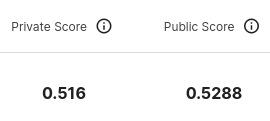

Без обработки качество модели лучше... это странно, но думаю этому есть объяснение



**Попробуем модель resnet50. Ее недостаток - необходимость подавать на вход IMAGE_SIZE = 224, что замедляет обучение**

In [ ]:
IMAGE_SIZE = 224

In [ ]:

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

In [ ]:
train_data_gen, val_data_gen, labels_dict = loading_dataset(version_ds = 1, bath_size = BATCH_SIZE, image_size = IMAGE_SIZE)

Found 35133 images belonging to 9 classes.
Found 8780 images belonging to 9 classes.


In [ ]:


!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications --no-deps
filename = "/usr/local/lib/python3.8/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
# import tensorflow as tf

from keras_vggface.vggface import VGGFace





Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-9e4j28fz
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-9e4j28fz
  Resolved https://github.com/rcmalli/keras-vggface.git to commit 719ad75625fe51436b9a9479114b3d136847e11a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8325 sha256=2dde5212940b11dcd0bf575abb7101003e4ae86bf97dc5257fe872e19ef25a9e
  Stored in directory: /tmp/pip-ephem-wheel-cache-vrnojc9k/wheels/24/de/3d/9a0fad8c64abbc63b7fb8ddcdf1aa0a4c04a98d7936e989a29
Successfully built keras-vggface
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 4.7 MB/s eta 0:00:00


In [ ]:
# import keras_vggface.vggface
# import keras.utils.topology 
path = Path("/content/drive/My Drive/diplom/model_save_ocv/checkpoint_best224_FR_22-02.h5")
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

vggface_model = VGGFace(model='resnet50', include_top=False,
                        input_shape=IMG_SHAPE) # or VGGFace() as default
# vggface_model = VGGFace(model='resnet50', include_top=False,
#                         input_shape=(224, 224, 3))




# vggface_model = tf.keras.applications.resnet50.ResNet50(model='resnet50', include_top=False,
#                         input_shape=IMG_SHAPE)
vggface_model.trainable = True

94694792/94694792 [==============================] - 6s 0us/step


**Структура модели (для презентации)**

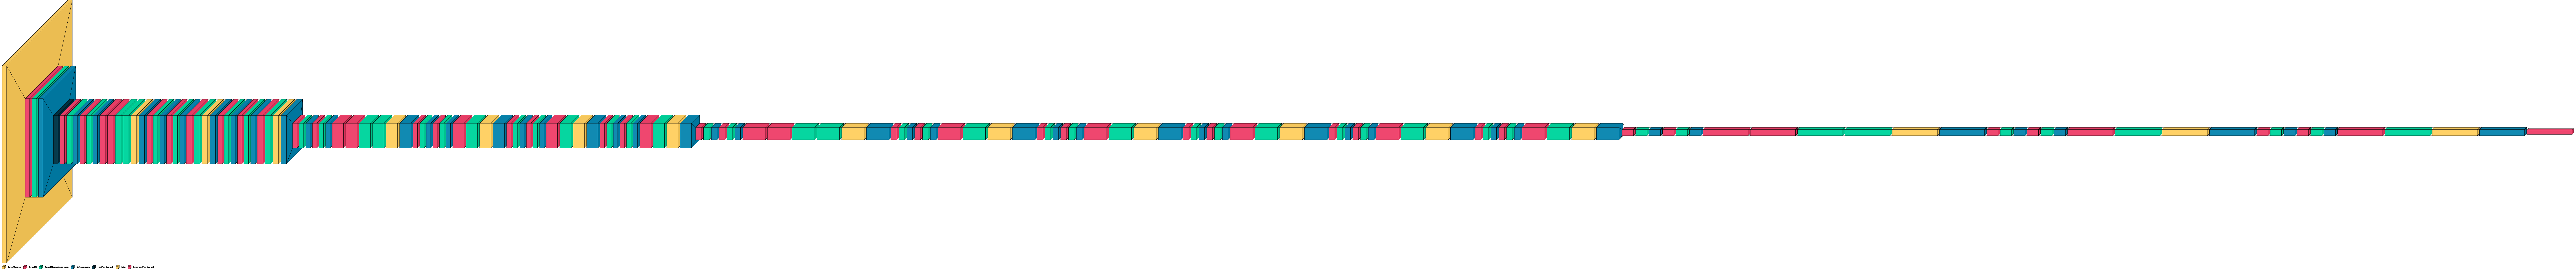

In [ ]:
visualkeras.layered_view(vggface_model, legend = True)

In [ ]:
model = tf.keras.Sequential([
    vggface_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9)])
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3))

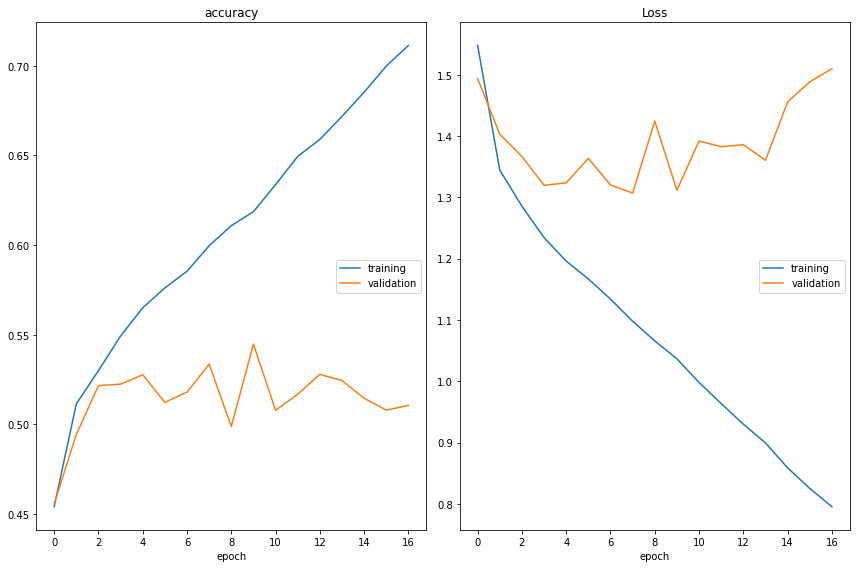

accuracy
	training         	 (min:    0.454, max:    0.711, cur:    0.711)
	validation       	 (min:    0.456, max:    0.545, cur:    0.511)
Loss
	training         	 (min:    0.795, max:    1.548, cur:    0.795)
	validation       	 (min:    1.307, max:    1.510, cur:    1.510)

Epoch 17: val_accuracy did not improve from 0.54476
549/549 [==============================] - 1225s 2s/step - loss: 0.7952 - accuracy: 0.7113 - val_loss: 1.5100 - val_accuracy: 0.5106
Epoch 18/30
233/549 [===========>..................] - ETA: 8:42 - loss: 0.7372 - accuracy: 0.7255

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

EPOCHS = 30
history = model.fit_generator(train_data_gen,
                              epochs=EPOCHS,
                              validation_data=val_data_gen,
                              use_multiprocessing = True,
                              callbacks=[PlotLossesCallback(), checkpoint])

In [ ]:
# загрузка модели
path = Path("/content/drive/My Drive/diplom/model_save_ocv/checkpoint_best224_FR_22-02.h5")
model = tf.keras.models.load_model(path)

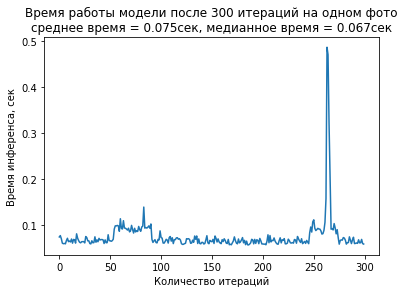

(0.07493914683659872, 0.06706440448760986)

In [ ]:
%%capture --no-display
test_time_model(model = model)

Время работы около 70 милисекунд на итерацию

In [ ]:
%%capture --no-display
output_predict = TraverFolders(rootDir='/content/test_kaggle', model = model, img_size = IMAGE_SIZE)
output_predict.to_csv('/content/drive/MyDrive/diplom/predict_df_fr_resnet_23.02.csv', index=False) 
output_predict.head()

,image_path,emotion
0,0.jpg,sad
1,1.jpg,neutral
2,2.jpg,sad
3,3.jpg,anger
4,4.jpg,neutral


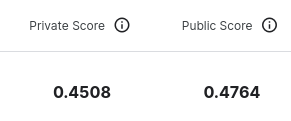

Качество модели на kaggle хуже. На оригинальном датасете проверять не будем, так как долго.

**Следующую любопытную модель нашел в исходниках VGG19. Очередная модификация, заходелось протестировать**

In [ ]:
IMAGE_SIZE = 128
NUM_CLASSES = 9
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)
train_data_gen, val_data_gen, labels_dict = loading_dataset(version_ds = 1, bath_size = BATCH_SIZE, image_size = IMAGE_SIZE)
path = Path("/content/drive/My Drive/diplom/model_save_ocv/checkpoint128_bestNewvgg128_FR_23-02.h5")
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

Found 35133 images belonging to 9 classes.
Found 8780 images belonging to 9 classes.


In [ ]:
"""
Programmed by the-robot <https://github.com/the-robot>
"""

from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPooling2D,
)
from tensorflow.keras import Model
import tensorflow as tf
import typing

tf.config.run_functions_eagerly(True)

@tf.function
def VGGNet(
    name: str,
    architecture: typing.List[ typing.Union[int, str] ],
    input_shape: typing.Tuple[int],
    classes: int = 1000
) -> Model:
    """
    Implementation of the VGGNet architecture.
    Arguments:
    name         -- name of the architecture
    architecture -- number of output channel per convolution layers in VGGNet
    input_shape  -- shape of the images of the dataset
    classes      -- integer, number of classes
    Returns:
    model        -- a Model() instance in Keras
    """

    # convert input shape into tensor
    X_input = Input(input_shape)

    # make convolution layers
    X = make_conv_layer(X_input, architecture)

    # flatten the output and make fully connected layers
    X = Flatten()(X)
    X = make_dense_layer(X, 4096)
    X = make_dense_layer(X, 1024)

    # classification layer
    # X = Dense(units = classes, activation = "softmax")(X)
    X = Dense(units = classes)(X)
    model = Model(inputs = X_input, outputs = X, name = name)
    return model

def make_conv_layer(
    X: tf.Tensor,
    architecture: typing.List[ typing.Union[int, str] ],
    activation: str = 'relu'
) -> tf.Tensor:
    """
    Method to create convolution layers for VGGNet.
    In VGGNet
        - Kernal is always 3x3 for conv-layer with padding 1 and stride 1.
        - 2x2 kernel for max pooling with stride of 2.
    Arguments:
    X            -- input tensor
    architecture -- number of output channel per convolution layers in VGGNet
    activation   -- type of activation method
    Returns:
    X           -- output tensor
    """

    for output in architecture:

        # convolution layer
        if type(output) == int:
            out_channels = output

            X = Conv2D(
                filters = out_channels,
                kernel_size = (3, 3),
                strides = (1, 1),
                padding = "same"
            )(X)
            X = BatchNormalization()(X)
            X = Activation(activation)(X)

            # relu activation is added (by default activation) so that all the
            # negative values are not passed to the next layer

        # max-pooling layer
        else:
            
            
            X = MaxPooling2D(
                pool_size = (2, 2),
                strides = (2, 2)
            )(X)

    return X

def make_dense_layer(X: tf.Tensor, output_units: int, dropout = 0.5, activation = 'relu') -> tf.Tensor:
    """
    Method to create dense layer for VGGNet.
    Arguments:
    X            -- input tensor
    output_units -- output tensor size
    dropout      -- dropout value for regularization
    activation   -- type of activation method
    Returns:
    X            -- input tensor
    """

    X = Dense(units = output_units)(X)
    X = BatchNormalization()(X)
    X = Activation(activation)(X)
    X = Dropout(dropout)(X)

    return X


In [ ]:
model = VGGNet(
    name = 'img',
    architecture = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    input_shape = IMG_SHAPE,
    classes = NUM_CLASSES
)


**Посмотрим на структуру модели**

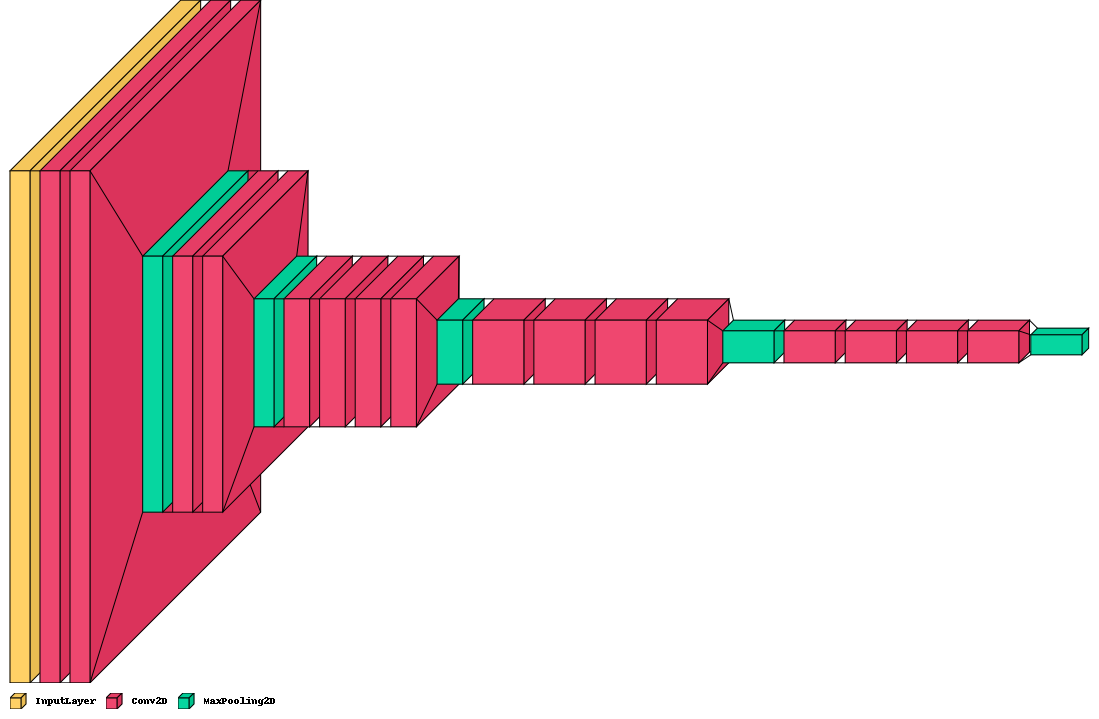

In [ ]:
visualkeras.layered_view(base_model, legend = True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

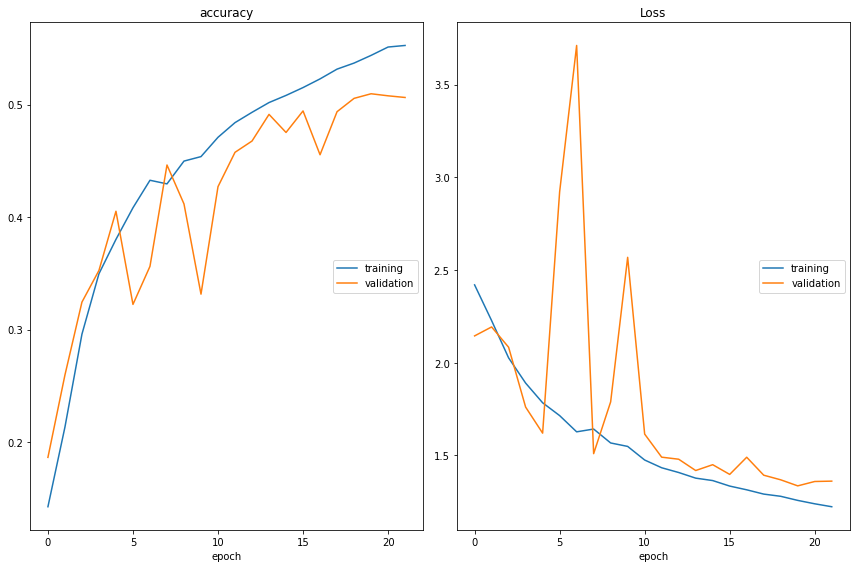

accuracy
	training         	 (min:    0.143, max:    0.553, cur:    0.553)
	validation       	 (min:    0.186, max:    0.510, cur:    0.506)
Loss
	training         	 (min:    1.223, max:    2.420, cur:    1.223)
	validation       	 (min:    1.336, max:    3.711, cur:    1.361)

Epoch 22: val_accuracy did not improve from 0.50968
549/549 [==============================] - 601s 1s/step - loss: 1.2233 - accuracy: 0.5526 - val_loss: 1.3613 - val_accuracy: 0.5064


KeyboardInterrupt: ignored

In [ ]:

EPOCHS = 30
history = model.fit_generator(train_data_gen,
                              epochs=EPOCHS,
                              validation_data=val_data_gen,
                              use_multiprocessing = True,
                              callbacks=[PlotLossesCallback(), checkpoint])

In [ ]:
# загрузка модели
path = Path("/content/drive/My Drive/diplom/model_save_ocv/checkpoint128_bestNewvgg128_FR_23-02.h5")
model = tf.keras.models.load_model(path)

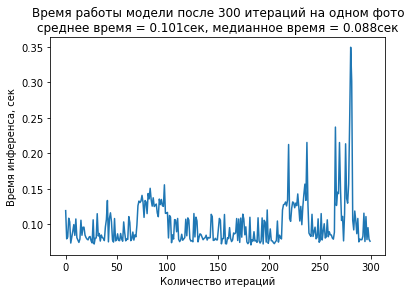

(0.10057928005854289, 0.08755671977996826)

In [ ]:
%%capture --no-display
test_time_model(model = model)

In [ ]:
%%capture --no-display
output_predict = TraverFolders(rootDir='/content/test_kaggle', model = model, img_size = IMAGE_SIZE)
output_predict.to_csv('/content/drive/MyDrive/diplom/checkpoint128_bestNewvgg128_FR_23.02.csv', index=False) 
output_predict.head()

,image_path,emotion
0,0.jpg,sad
1,1.jpg,neutral
2,2.jpg,sad
3,3.jpg,uncertain
4,4.jpg,contempt


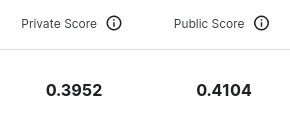

**Нашел похожий датасет AffectNet-HQ, который позволяет дополнить изначальный датасет и улучшить качество модели**

https://www.kaggle.com/datasets/tom99763/affectnethq

**Распакуем архивы и разложим изображения по соотвествующим папкам**

In [ ]:
# путь к тренировочному файлу
train_zip_file = '/content/drive/MyDrive/diplom/train.zip'
# распаковать файлы
train_files = zipfile.ZipFile(train_zip_file, 'r')
train_files.extractall()

In [ ]:
# путь к тренировочному файлу
train_zip_file = '/content/drive/MyDrive/diplom/datasets/archive.zip'
# распаковать файлы
train_files = zipfile.ZipFile(train_zip_file, 'r')
train_files.extractall('/content/archive')

In [ ]:
# # путь к тренировочному файлу
# train_zip_file = '/content/drive/MyDrive/diplom/datasets/archive3.zip'
# # распаковать файлы
# train_files = zipfile.ZipFile(train_zip_file, 'r')
# train_files.extractall('/content/archive3')

In [ ]:
!cp -r archive/anger/ train
!cp -r archive/contempt/ train
!cp -r archive/disgust/ train
!cp -r archive/fear/ train
!cp -r archive/happy/ train
!cp -r archive/neutral/ train
!cp -r archive/sad/ train
!cp -r archive/surprise/ train

# !cp -r archive3/test/angry/. train/anger/.
# !cp -r archive3/test/disgust/. train/disgust/.
# !cp -r archive3/test/fear/. train/fear/.
# !cp -r archive3/test/surprise/. train/surprise/.
# !cp -r archive3/test/happy/. train/happy/.
# !cp -r archive3/test/neutral/. train/neutral/.
# !cp -r archive3/test/sad/. train/sad/.

# !cp -r archive3/train/angry/. train/anger/.
# !cp -r archive3/train/disgust/. train/disgust/.
# !cp -r archive3/train/fear/. train/fear/.
# !cp -r archive3/train/surprise/. train/surprise/.
# !cp -r archive3/train/happy/. train/happy/.
# !cp -r archive3/train/neutral/. train/neutral/.
# !cp -r archive3/train/sad/. train/sad/.

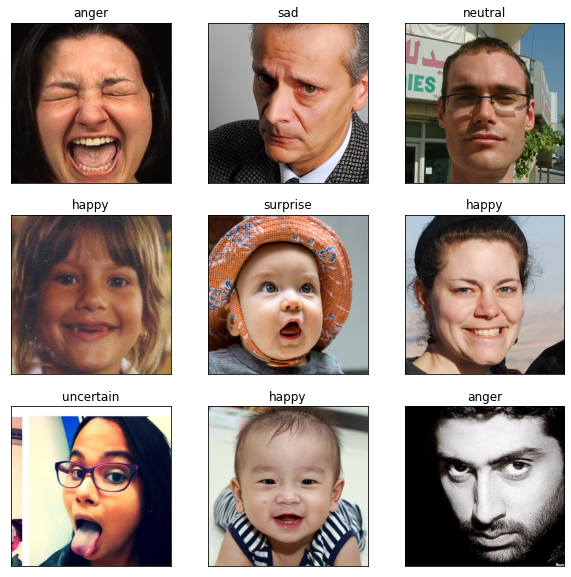

In [ ]:
data_dir = '/content/train'
show_image(data_dir)

Всего файлов:  81049


<BarContainer object of 9 artists>

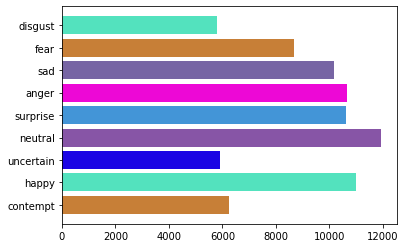

In [ ]:
# проведем разведочный анализ (для презентации)
# количество файлов по папкам

class_names = ['contempt',
 'happy',
 'uncertain',
 'neutral',
 'surprise',
 'anger',
 'sad',
 'fear',
 'disgust']

print('Всего файлов: ', len(glob.glob(data_dir+'/*/*.*')))

count_img = []
for i in class_names:
  count_img.append(len(glob.glob(data_dir+'/'+i+'/*.*')))

plt.barh(class_names, count_img, color = np.random.rand(7, 3))

**Попробуем модель VGG19**

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = 128
data_dir = '/content/train'
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input, # препроцессинг
                            validation_split=0.2, # размер валидационной выборки, так как всё берётся из одной папки
                            rotation_range=5,  # максимальный угол поворота
                            width_shift_range=0.1, # смещение максимум на 10% ширины по горизонтали
                            height_shift_range=0.1, # смещение максимум на 10% высоты по вертикали
                            zoom_range=0.1, # картинка будет увеличена или уменьшена не более чем на 10%
                            brightness_range=(0.4, 1.0), # сдвиг яркости
                            channel_shift_range=80.0, # случайный сдвиг каналов
                            shear_range = 0.1, # Интенсивность сдвига (угол сдвига против часовой стрелки в градусах)
                            horizontal_flip=True, # случайное отражение по горизонтали
                            fill_mode="nearest") # чем заполнять пробелы

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE, # размер батча  
                                              directory=data_dir, # директория для доступа к изображениям
                                              shuffle=True, # перемешивать ли данные 
                                              target_size=(IMAGE_SIZE,IMAGE_SIZE), # размер изображения
                                              class_mode="categorical", # тип классового распределения
                                              subset = "training") # указываем, что данная выборка тренировочная 

val_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                            directory=data_dir,
                                            shuffle=False,
                                            target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                            class_mode='categorical',
                                            subset = "validation") # указываем, что данная выборка валидационная 

Found 64842 images belonging to 9 classes.
Found 16207 images belonging to 9 classes.


In [ ]:
NUM_CLASSES = 9
IMAGE_SIZE = 128
BATCH_SIZE = 64
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

In [ ]:

path = Path("/content/drive/My Drive/diplom/model_save_ocv/checkpoint_best128_new_DS_24-02.h5")
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet') 
base_model.trainable = True

80134624/80134624 [==============================] - 6s 0us/step


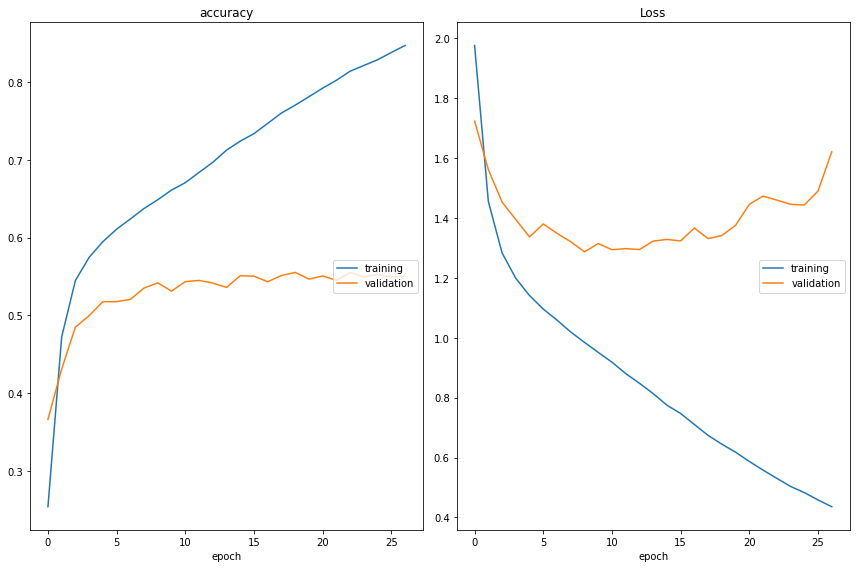

accuracy
	training         	 (min:    0.254, max:    0.847, cur:    0.847)
	validation       	 (min:    0.366, max:    0.555, cur:    0.550)
Loss
	training         	 (min:    0.436, max:    1.976, cur:    0.436)
	validation       	 (min:    1.287, max:    1.724, cur:    1.621)

Epoch 27: val_accuracy did not improve from 0.55525
1014/1014 [==============================] - 1469s 1s/step - loss: 0.4357 - accuracy: 0.8470 - val_loss: 1.6208 - val_accuracy: 0.5502
Epoch 28/30
 410/1014 [===========>..................] - ETA: 12:46 - loss: 0.4050 - accuracy: 0.8575

In [ ]:
model = tf.keras.Sequential([base_model,
                            tf.keras.layers.GlobalAveragePooling2D(),
                            tf.keras.layers.Dense(1024, activation="relu"),
                            tf.keras.layers.Dropout(0.3),
                            tf.keras.layers.Dense(NUM_CLASSES)])

"""

"""

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

EPOCHS = 30
history = model.fit_generator(train_data_gen,
                              epochs=EPOCHS,
                              validation_data=val_data_gen,
                              use_multiprocessing = True,
                              callbacks=[PlotLossesCallback(), checkpoint])

**Проверим качество модели - время инференса и результаты на kaggle**

In [ ]:
# загрузка модели
path = Path("/content/drive/My Drive/diplom/model_save_ocv/checkpoint_best128_new_DS_24-02.h5")
model = tf.keras.models.load_model(path)

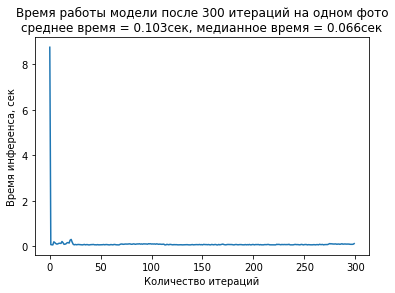

(0.10251497189203898, 0.06609690189361572)

In [ ]:
%%capture --no-display
test_time_model(model = model)

Время инференса около 70 милисекунд на итерацию

In [ ]:
%%capture --no-display
output_predict = TraverFolders(rootDir='/content/test_kaggle', model = model, img_size = IMAGE_SIZE)
output_predict.to_csv('/content/drive/MyDrive/diplom/checkpoint_best128_new_DS_24.02.csv', index=False) 
output_predict.head()

,image_path,emotion
0,0.jpg,sad
1,1.jpg,neutral
2,2.jpg,sad
3,3.jpg,disgust
4,4.jpg,neutral


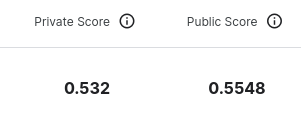

Результаты на kaggle самые лучшие

**VALENCE-AROUSAL модель**

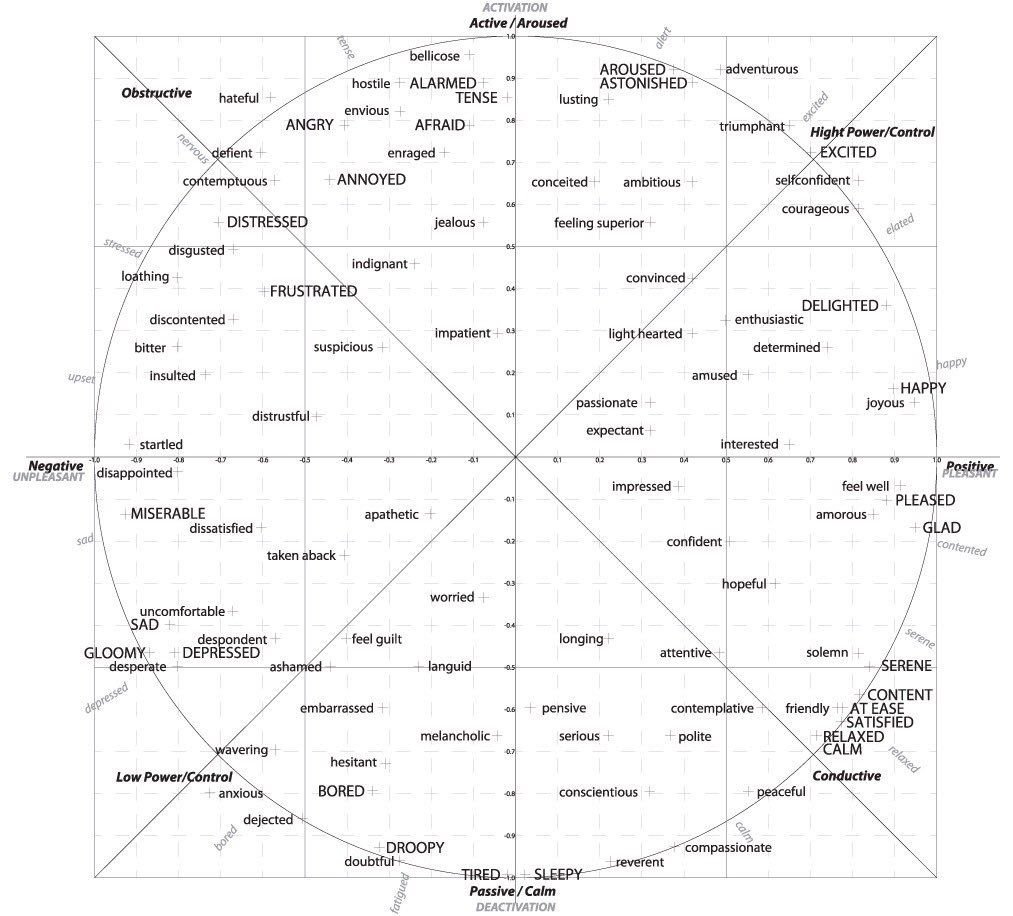

**Модель valence-arousal подразумевает классификацию эмоций по двум параметрам - их валентности (valence) и интенсивности (arousal). Для обучения выполним распределение эмоций синтетически, т.к. исходный датасет не размечен по данной метрике. Для разделения используем вышеприведенную схему и рандомные отклонения координат по условным окружностям**

Для обучения используем исходный датасет (без обработки и расширения)



In [2]:
# путь к тренировочному файлу
train_zip_file = '/content/drive/MyDrive/diplom/train.zip'
# распаковать файлы
train_files = zipfile.ZipFile(train_zip_file, 'r')
train_files.extractall()

In [3]:
# fisrt number - valence, second - arousal
VA_emotions = {
    'anger':    [ -4, 8],   # гнев
    'contempt': [ -6, -1.8],   # презрение
    'disgust':  [ -6.8,  5],   # отвращение
    'fear':     [ -2.5,  5],   # страх
    'happy':    [ 9,  1.7],   # радость
    'neutral':  [ 0,  0],   # безразличие
    'sad':      [ -8.2,  -4],   # грусть
    'surprise': [ 8,  6.4],   # удивление
    'uncertain':[ -4,  0]    # неопределенность
}

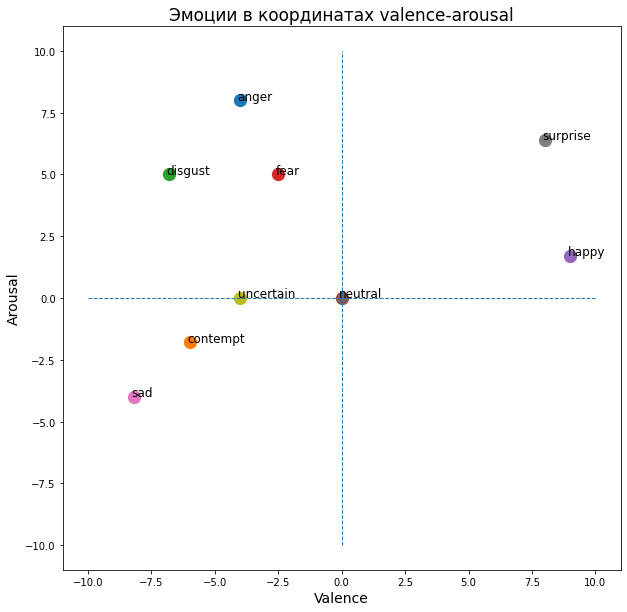

In [4]:
# drawing points of given emotions
fig, ax = plt.subplots(figsize=(10,10))
for emotion, (v, a) in VA_emotions.items():
    plt.scatter(v, a, label=emotion, s=150)
    plt.text(v-0.1, a+0.03, emotion, size=12)
# plt.xlim(1,7)
# plt.ylim(1,7)
plt.vlines(0, -10, 10, linestyle='dashed', lw=1)
plt.hlines(0, -10, 10, linestyle='dashed', lw=1)
plt.xlabel('Valence', size=14)
plt.ylabel('Arousal', size=14)
plt.title('Эмоции в координатах valence-arousal', size=17)
plt.show()


Фукнция, которые выдает случайные координаты внутри окружности, заданного радиуса

In [5]:

def circle (radius):
  r = np.random.uniform(low=0, high=radius**2)
  theta = np.random.uniform(low=0, high=2*np.pi)
  x = np.sqrt(r) * np.cos(theta)
  y = np.sqrt(r) * np.sin(theta)
  return (x,y)

In [9]:

# targ_folder = '/content/drive/MyDrive/train'


df_corrupt = dict()

rootDir = '/content/train'


idx = 0
for lists in os.listdir(rootDir): # перебирает папки с эмоциями

    path = os.path.join(rootDir, lists)
    # target_path = os.path.join(targ_folder, lists)
    # if not os.path.exists(target_path):
    #   # Каталог не существует, создайте операцию
    #   os.makedirs(target_path)  

    # print(v,a)
    for img_name in tqdm(os.listdir(path)): # перебирает имена файлов
        img_path = os.path.join(path, img_name) # объединяет имена файлов с путями
        VA_emotions
        x, y = circle(1)
        # print(x, y)
        v = VA_emotions[lists][0]+x
        a = VA_emotions[lists][1]+y

        df_corrupt[idx] = {'path': img_path, 'emotion':lists, 'valence':np.array(v, dtype=np.float), 'arousal':np.array(a, dtype=np.float)}
        idx += 1                  
        
va_df = pd.DataFrame(df_corrupt).T
va_df['valence']=va_df['valence'].astype('float')
va_df['arousal']=va_df['arousal'].astype('float')

100%|██████████| 5955/5955 [00:00<00:00, 35143.64it/s]


In [10]:
va_df.head()

,path,emotion,valence,arousal
0,/content/train/sad/3726.jpg,sad,-7.831078,-3.272903
1,/content/train/sad/4726.jpg,sad,-8.150232,-4.868018
2,/content/train/sad/432.jpg,sad,-8.341662,-3.520134
3,/content/train/sad/3826.jpg,sad,-8.441471,-4.939359
4,/content/train/sad/4174.jpg,sad,-7.754196,-3.924889


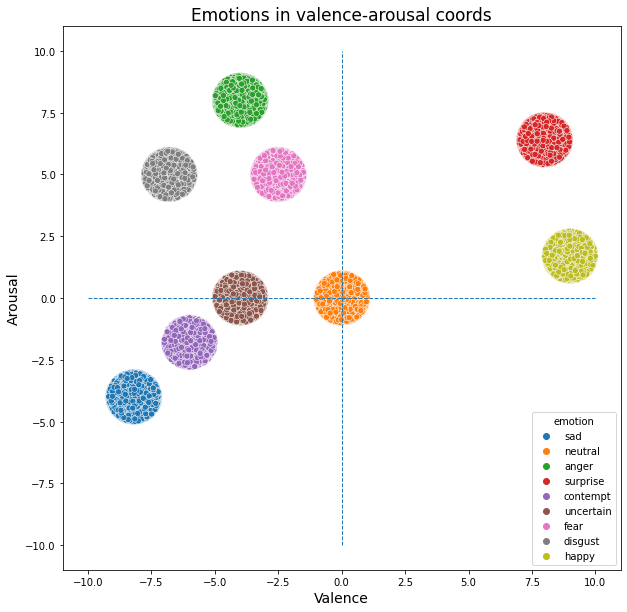

In [11]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))
# plt.xlim(1,7)
# plt.ylim(1,7)
plt.vlines(0, -10, 10, linestyle='dashed', lw=1)
plt.hlines(0, -10, 10, linestyle='dashed', lw=1)
plt.xlabel('Valence', size=14)
plt.ylabel('Arousal', size=14)
plt.title('Emotions in valence-arousal coords', size=17)
ax = sns.scatterplot(x = 'valence', y = 'arousal', data = va_df, hue = 'emotion')
plt.show()



In [ ]:
# train_df = va_df.sample(frac=0.8,random_state=200)
# test_df = va_df.drop(train_df.index)

Выполним аугментацию данных с использованием flow_from_dataframe

In [12]:

# train generator with augmentation
BATCH_SIZE = 64
IMAGE_SIZE = 128
data_dir = '/content/train'
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input, # препроцессинг
                            validation_split=0.2, # размер валидационной выборки, так как всё берётся из одной папки
                            rotation_range=5,  # максимальный угол поворота
                            width_shift_range=0.1, # смещение максимум на 10% ширины по горизонтали
                            height_shift_range=0.1, # смещение максимум на 10% высоты по вертикали
                            zoom_range=0.1, # картинка будет увеличена или уменьшена не более чем на 10%
                            brightness_range=(0.4, 1.0), # сдвиг яркости
                            channel_shift_range=80.0, # случайный сдвиг каналов
                            shear_range = 0.1, # Интенсивность сдвига (угол сдвига против часовой стрелки в градусах)
                            horizontal_flip=True, # случайное отражение по горизонтали
                            fill_mode="nearest") # чем заполнять пробелы

train_data_gen = image_gen.flow_from_dataframe(dataframe=va_df,
                                              x_col='path',
                                              y_col=['valence','arousal'],
                                              batch_size=BATCH_SIZE, # размер батча  
                                              # directory=data_dir, # директория для доступа к изображениям
                                              shuffle=True, # перемешивать ли данные 
                                              target_size=(IMAGE_SIZE,IMAGE_SIZE), # размер изображения
                                              subset = "training",
                                              class_mode="raw") # тип классового распределения
                                               # указываем, что данная выборка тренировочная 


# val_image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_data_gen = image_gen.flow_from_dataframe(dataframe=va_df,
                                            x_col='path',
                                            y_col=['valence','arousal'],
                                            batch_size=BATCH_SIZE,
                                            # directory=data_dir,
                                            shuffle=False,
                                            target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                            subset = "validation",
                                            class_mode='raw') # указываем, что данная выборка валидационная 

Found 40038 validated image filenames.
Found 10009 validated image filenames.


In [ ]:

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-4,
#     decay_steps=100,
#     decay_rate=0.9)

In [ ]:

path = Path('/content/drive/My Drive/diplom/model_save_ocv/')
cpt_filename = "{epoch:02d}_checkpoint_{val_loss:.2f}_{val_mean_absolute_error:.2f}.hdf5"  
path = str(path / cpt_filename)

# path = Path("/content/drive/My Drive/diplom/model_save_ocv/checkpoint_best128_new_VA_02-03.h5")
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9)

    

base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet') 
base_model.trainable = True

In [ ]:
model = tf.keras.Sequential([base_model,
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(512, activation='relu'),
                                tf.keras.layers.Dropout(0.2),
                                tf.keras.layers.Dense(2)])
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3))
model.summary()
"""

"""

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics='mean_absolute_error')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,220,226
Trainable params: 24,220,226
Non-trainable params: 0
_________________________________________________________________


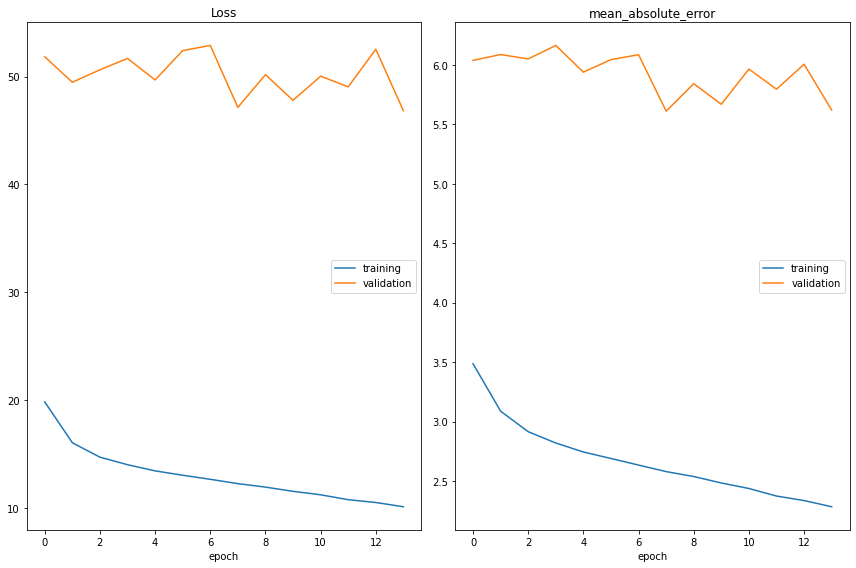

Loss
	training         	 (min:   10.119, max:   19.838, cur:   10.119)
	validation       	 (min:   46.839, max:   52.890, cur:   46.839)
mean_absolute_error
	training         	 (min:    2.283, max:    3.486, cur:    2.283)
	validation       	 (min:    5.610, max:    6.163, cur:    5.620)

Epoch 14: saving model to /content/drive/My Drive/diplom/model_save_ocv/14_checkpoint_46.84_5.62.hdf5
626/626 [==============================] - 623s 995ms/step - loss: 10.1194 - mean_absolute_error: 2.2833 - val_loss: 46.8387 - val_mean_absolute_error: 5.6199
Epoch 15/30
 10/626 [..............................] - ETA: 7:32 - loss: 9.2875 - mean_absolute_error: 2.2296

KeyboardInterrupt: ignored

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_mean_absolute_error', verbose=1, save_best_only=False, save_freq='epoch', mode='min')

EPOCHS = 30
history = model.fit(train_data_gen,
                              epochs=EPOCHS,
                              validation_data=val_data_gen,
                              # use_multiprocessing = True,
                              callbacks=[PlotLossesCallback(), checkpoint])

Модель не удалась. Возможно какая-то ошибка, обучается очень сложно и долго.
Ниже - продолжение обучения

In [13]:

path = Path("/content/drive/My Drive/diplom/model_save_ocv/23_checkpoint_32.99_5.10.hdf5")
model = tf.keras.models.load_model(path)

In [14]:
path = Path('/content/drive/My Drive/diplom/model_save_ocv/')
cpt_filename = "{epoch:02d}_checkpoint_{val_loss:.2f}_{val_mean_absolute_error:.2f}.hdf5"  
path = str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_mean_absolute_error', verbose=1, save_best_only=False, save_freq='epoch', mode='min')

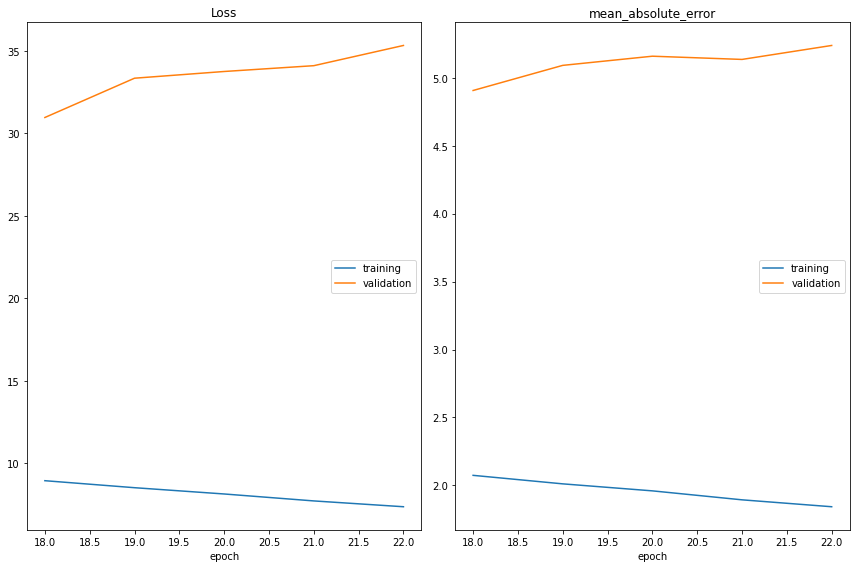

Loss
	training         	 (min:    7.369, max:    8.948, cur:    7.369)
	validation       	 (min:   30.970, max:   35.337, cur:   35.337)
mean_absolute_error
	training         	 (min:    1.843, max:    2.074, cur:    1.843)
	validation       	 (min:    4.907, max:    5.238, cur:    5.238)

Epoch 23: saving model to /content/drive/My Drive/diplom/model_save_ocv/23_checkpoint_35.34_5.24.hdf5
626/626 [==============================] - 672s 1s/step - loss: 7.3692 - mean_absolute_error: 1.8426 - val_loss: 35.3373 - val_mean_absolute_error: 5.2384
Epoch 24/50
471/626 [=====================>........] - ETA: 2:17 - loss: 7.0101 - mean_absolute_error: 1.7917

In [ ]:
EPOCHS = 50
history = model.fit(train_data_gen,
                              epochs=EPOCHS,
                              initial_epoch=18,
                              validation_data=val_data_gen,
                              # use_multiprocessing = True,
                              callbacks=[PlotLossesCallback(), checkpoint])

**Загрузка датасета для проверки на kaggle**

In [6]:
# путь к тестовому файлу

test_zip_file = '/content/drive/MyDrive/diplom/test_kaggle.zip'

# распаковать файлы
test_files = zipfile.ZipFile(test_zip_file, 'r')
test_files.extractall()


In [7]:

path = Path("/content/drive/My Drive/diplom/model_save_ocv/18_checkpoint_30.76_4.89.hdf5")
model = tf.keras.models.load_model(path)

In [8]:
IMAGE_SIZE = 128

In [9]:
from scipy import spatial
# функция для формирования датасета в целях проверки качества модели на kaggle
def TraverFolders_VA(rootDir, model, img_size):
  '''
  rootDir - путь к тестовому датасету, по умолчанию /content/test_kaggle
  сохраняет датафрейм в predict_df_sort
  '''
  # count = 0
  img_dict = dict()
  idx = 0

  for lists in tqdm(os.listdir(rootDir)):
      # path = os.path.join(rootDir, lists)
      # img = cv2.imread(path)
      # img = cv2.resize(img, (img_size,img_size))
      # img = np.expand_dims(img, 0)
      
      # prediction = model(img).numpy()
      
      path = os.path.join(rootDir, lists)
      image = tf.keras.utils.load_img(path, target_size = (img_size, img_size))
      input_arr = tf.keras.utils.img_to_array(image)

      input_arr = preprocess_input(input_arr)
      input_arr = np.array([input_arr])  # Convert single image to a batch.
      
      predictions = model.predict(input_arr)

      # print(predictions[0][0])
      emotions = spatial.KDTree(list(VA_emotions.values()))
      emotion_number = int(emotions.query(predictions)[1])
      emotion_name = list(VA_emotions.keys())[emotion_number]


      emotion = emotion_name

      file_name = path[21:]
      file_numer = int(file_name[:-4])
      img_dict[idx] = {'path': path, 'image_path': file_name, 'emotion': emotion, 'fn': file_numer,'valence':predictions[0][0], 'arousal':predictions[0][1]}
      print(img_dict[idx])
      idx+=1

      # count +=1
      # if count >= 10:
      #   break

  predict_df = pd.DataFrame(img_dict).T


  return predict_df

In [10]:
%%capture --no-display
output_predict = TraverFolders_VA(rootDir='/content/test_kaggle', model = model, img_size = IMAGE_SIZE)
# output_predict.to_csv('/content/drive/MyDrive/diplom/checkpoint_best128_new_VA_28.02.csv', index=False) 
# output_predict.head()
# predict_df1.head()

In [11]:
filehandler = open("/content/drive/MyDrive/diplom/train_df_va1_test.obj","wb")
pickle.dump(output_predict,filehandler)
filehandler.close() 

In [12]:
file = open("/content/drive/MyDrive/diplom/train_df_va1_test.obj",'rb')
test_df_va = pickle.load(file)
file.close()

In [13]:
test_df_va['emotion'].unique()

array(['uncertain', 'fear', 'surprise', 'disgust', 'neutral', 'anger',
       'happy', 'contempt'], dtype=object)

In [14]:
test_df_va

,path,image_path,emotion,fn,valence,arousal
0,/content/test_kaggle/3825.jpg,3825.jpg,uncertain,3825,-2.514861,0.885486
1,/content/test_kaggle/1835.jpg,1835.jpg,fear,1835,-3.714082,5.107929
2,/content/test_kaggle/4741.jpg,4741.jpg,fear,4741,-2.653218,4.250577
3,/content/test_kaggle/3850.jpg,3850.jpg,surprise,3850,3.389686,5.211527
4,/content/test_kaggle/935.jpg,935.jpg,uncertain,935,-2.516617,0.83686
...,...,...,...,...,...,...
4995,/content/test_kaggle/943.jpg,943.jpg,fear,943,-3.9391,3.39423
4996,/content/test_kaggle/2873.jpg,2873.jpg,fear,2873,-3.171129,6.144202
4997,/content/test_kaggle/2104.jpg,2104.jpg,fear,2104,-2.858735,4.44064
4998,/content/test_kaggle/985.jpg,985.jpg,surprise,985,7.245291,4.132118


In [15]:
predict_df_sort = test_df_va.sort_values(by='fn', ignore_index=True)
# predict_df.set_index('fn')
# predict_df_sort = predict_df.sort_index()
predict_df_sort = predict_df_sort[['image_path', 'emotion']]
# print()
# predict_df_sort1 = predict_df_sort[['path', 'emotion', 'valence', 'arousal']]

In [16]:
predict_df_sort

,image_path,emotion
0,0.jpg,uncertain
1,1.jpg,neutral
2,2.jpg,fear
3,3.jpg,fear
4,4.jpg,uncertain
...,...,...
4995,4995.jpg,surprise
4996,4996.jpg,fear
4997,4997.jpg,neutral
4998,4998.jpg,fear


In [17]:
predict_df_sort.to_csv('/content/drive/MyDrive/diplom/checkpoint128_bestNewvgg128_VR_04.03.csv', index=False) 

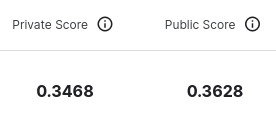

Эта модель показала плохие результаты. Думаю, одно дело выполнять классификацию по тысячам признаков (более качественнее), другое - превращать их в две цифры и тогда классифицировать. Очевидно, такое упрощение не работает.

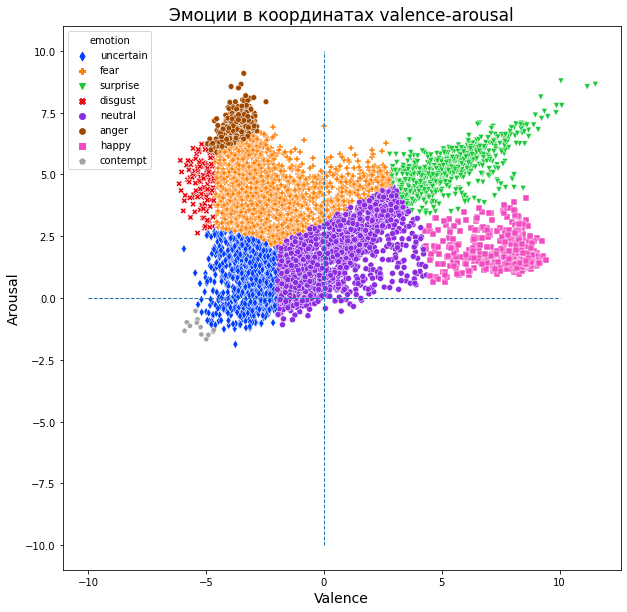

In [20]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))
# plt.xlim(1,7)
# plt.ylim(1,7)
plt.vlines(0, -10, 10, linestyle='dashed', lw=1)
plt.hlines(0, -10, 10, linestyle='dashed', lw=1)
plt.xlabel('Valence', size=14)
plt.ylabel('Arousal', size=14)
plt.title('Эмоции в координатах valence-arousal', size=17)

markers = {'anger': '8', 
           'contempt': 'p', 
           'disgust': 'X', 
           'fear': 'P', 
           'happy':'s', 
           'neutral':'o', 
           'sad':'*', 
           'surprise':'v', 
           'uncertain':'d'}

sns.scatterplot(x='valence', y='arousal', data=test_df_va,
                hue='emotion', palette='bright', style='emotion', markers=markers)
plt.show()